Original shape: (7032, 31)
Raw churn unique values: [0 1] 

Churn already numeric; no mapping applied.
Dropped 0 rows with invalid churn → new shape (7032, 31)

Best k=19 with CV accuracy 0.7874


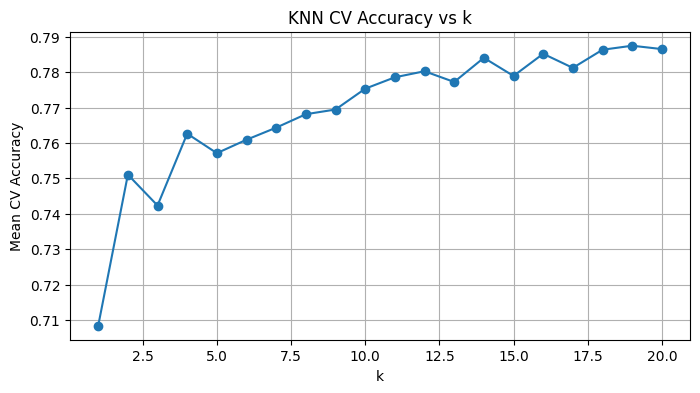


Test Accuracy: 0.7804
              precision    recall  f1-score   support

    No Churn       0.85      0.86      0.85      1291
       Churn       0.59      0.57      0.58       467

    accuracy                           0.78      1758
   macro avg       0.72      0.71      0.72      1758
weighted avg       0.78      0.78      0.78      1758



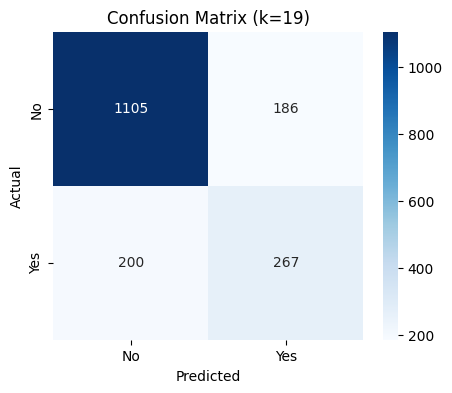

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load data
df = pd.read_csv('/Users/limengfeiyang/CMOR438-final-project/data/telco_churn_clean.csv')
print(f"Original shape: {df.shape}")
print("Raw churn unique values:", df['Churn'].unique(), "\n")


# Clean & map the Churn column
if df['Churn'].dtype == object:
    # strip whitespace and standardize case
    churn_str = df['Churn'].str.strip().str.lower()
    # map yes/no to 1/0
    df['Churn'] = churn_str.map({'no': 0, 'yes': 1})
    print("After mapping, churn unique:", df['Churn'].unique())
else:
    print("Churn already numeric; no mapping applied.")


# Drop rows where mapping failed
before = df.shape[0]
df = df[df['Churn'].notna()].copy()
after = df.shape[0]
print(f"Dropped {before - after} rows with invalid churn → new shape {df.shape}")
df['Churn'] = df['Churn'].astype(int)


# Drop ID
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)


# One-hot encode any remaining object columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


# Split out X and y
X = df.drop('Churn', axis=1).values
y = df['Churn'].values


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# GridSearch for k=1…20
param_grid = {'n_neighbors': list(range(1, 21))}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
best_k = grid.best_params_['n_neighbors']
print(f"\nBest k={best_k} with CV accuracy {grid.best_score_:.4f}")


# Plot CV accuracy
plt.figure(figsize=(8,4))
plt.plot(param_grid['n_neighbors'], grid.cv_results_['mean_test_score'], marker='o')
plt.xlabel('k'); plt.ylabel('Mean CV Accuracy')
plt.title('KNN CV Accuracy vs k')
plt.grid(True)
plt.show()


# Final eval
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=['No Churn','Churn']))


# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No','Yes'], yticklabels=['No','Yes'])
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title(f'Confusion Matrix (k={best_k})')
plt.show()
